In [1]:
!pip install --upgrade numpy shap transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


In [1]:
import numpy as np
import shap
import transformers
from transformers import ZeroShotClassificationPipeline
from typing import Union, List

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
shap.__version__

'0.42.1'

In [3]:
transformers.__version__

'4.31.0'

## Loading Hugging Face Pre-Trained models

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# DistilBart-MNLI is primarily a BART summarization model
model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-3")
tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-3")

### Setting Up the Model Pipeline

In [5]:
# Create a custom pipeline that only requires the text parameter
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

    def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [6]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [11]:
# Setting up the inference text data and the corresponding labels
text = ["tyler shut up before i smack u in your head"]
labels = ["safe","unsafe"]

In [7]:
text =["can someone kill me please. i hate life and i cant hang myself:("]
labels = ["safe", "unsafe"]

In [8]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Setting the on-the-fly labels to the model pipeline
pipe.set_labels(labels)

### SHAP for explainability

In [12]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

score_and_visualize(text, shap_values)

  0%|          | 0/156 [00:00<?, ?it/s]

Partition explainer: 2it [00:51, 51.83s/it]               


Model predictions are: [[{'label': 'unsafe', 'score': 0.702896237373352}, {'label': 'safe', 'score': 0.29710376262664795}]]


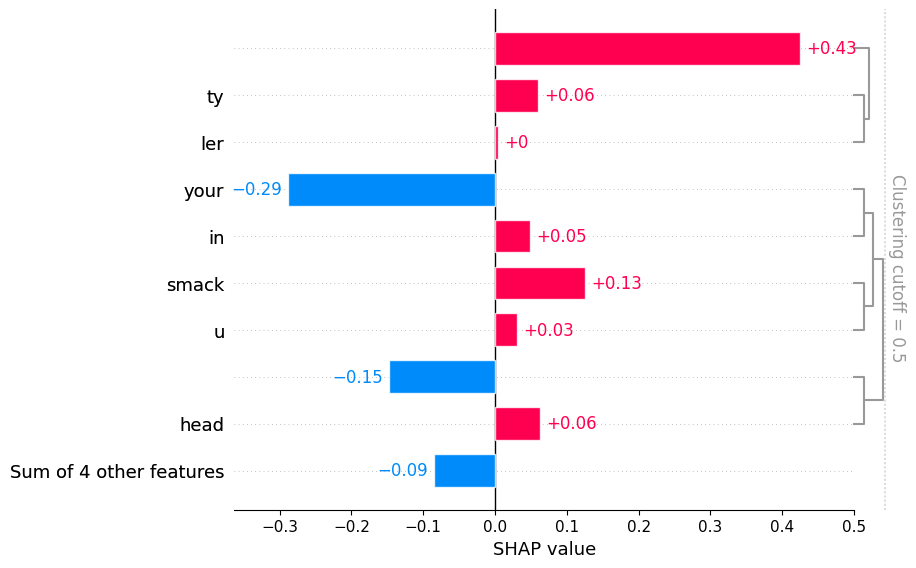

In [13]:
# Let's visualize the feature importance towards the outcome - unsafe
shap.plots.bar(shap_values[0,:,'unsafe'])

## DALEX

In [ ]:
!pip install dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1046001 sha256=76d4998e0626c539f5e9c1809a17c70d5c5c640496475c39e4dc2d0ff2589463
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


In [ ]:
import dalex as dx
dx.__version__

'1.6.0'

In [ ]:
# DALEX Explainer
exp = dx.Explainer(pipe)

Preparation of a new explainer is initiated

  -> data              : Not specified!
  -> target variable   : Not specified!
  -> model_class       : __main__.ZeroShotModelPipeline (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7f37e3f36f80> will be used (default)
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> model_info        : package __main__

A new explainer has been created!


In [ ]:
value = exp(text)

TypeError: ignored

In [ ]:
import pandas as pd
text_test = pd.DataFrame({'text': ['I love playing cricket!']},
                         index = ['text_test'])

In [ ]:
text_test

,text
text_test,I love playing cricket!


In [ ]:
# exp.predict(text_test)

In [ ]:
text = ['I love playing cricket']

In [ ]:
#exp.predict_parts(text_test.text[0], type='shap')